In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
my_font = FontProperties(fname=r"c:\windows\fonts\SimHei.ttf",size=12)

In [2]:
class WindDataSet(Dataset):
    def __init__(self,path,num_steps=50):
        self.data = []
        file = pd.read_csv(path,skiprows=1)
        self.feature = np.array(file[[ "Month", "Day", "Hour", "Minute", "surface air pressure (Pa)", "relative humidity at 2m (%)", "surface precipitation rate (mm/h)", "air temperature at 10m (C)", "wind direction at 10m (deg)","wind speed at 10m (m/s)"]])
        self.target = np.array(file["wind speed at 10m (m/s)"])
        wind_len = len(self.feature)
        for i in range(wind_len-num_steps-1):
            self.data.append((self.feature[i:i+num_steps],self.target[i+num_steps:i+num_steps+10]))
        self.data = self.data[:int(len(self.data)/250)*250]
    def __len__(self):
        return len(self.data)   
    def __getitem__(self,index):
        seq,pre = self.data[index]
        return seq,pre


In [3]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
try_gpu()

device(type='cpu')

In [4]:
INPUT_SIZE=10
HIDDEN_SIZE=50
BATCH_SIZE=250
OUTPUT_SIZE=10
NUM_LAYERS=2

class lstm(nn.Module):
    def __init__(self):
        super(lstm,self).__init__()
        self.rnn = nn.LSTM(input_size=INPUT_SIZE,hidden_size=HIDDEN_SIZE,num_layers=NUM_LAYERS)
        self.fc = nn.Linear(HIDDEN_SIZE,OUTPUT_SIZE)
    def forward(self,x,state):
        x = torch.transpose(x,dim0=0,dim1=1).reshape((x.shape[1],-1,INPUT_SIZE))
        out,state = self.rnn(x,state)
        out = self.fc(out)
        return out[-1],state
    def begin_state(self,batch_size,device):
        return (torch.zeros((2,batch_size,HIDDEN_SIZE),device=device),torch.zeros((2,batch_size, HIDDEN_SIZE), device=device))

In [5]:
net = lstm()
lr = 0.001
device = try_gpu()
print(device)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
loss = nn.MSELoss()
epochs = 10
num_steps=50

cpu


In [6]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

In [7]:

def train_epoch(epoch,net,train_loader,device,train_loss):
    net = net.to(device)
    net.train()
    runing_loss=0
    for batch_idx,(X,y) in enumerate(train_loader):
        state=net.begin_state(batch_size=BATCH_SIZE, device=device)
        for s in state:
            s.detach_()
        optimizer.zero_grad()
        X,y = X.to(torch.float32).to(device),y.to(torch.float32).to(device)
        y_hat,state = net(X,state)
        l = loss(y_hat,y).mean()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        runing_loss += l.item()
        if batch_idx%400 == 399:
            print(f'epoch:{epoch+1},batch_idx:{batch_idx+1},running_loss:{runing_loss/400}')
            train_loss.append(l.item())
            runing_loss=0


In [8]:
def save_net(path = 'wind_10input.pt', net=None):
    torch.save(net.state_dict(),path)
# save_net(net=net)

In [9]:
def train(epochs):
    train_loss = []
    for epoch in range(epochs):
        for i in range(120):
            dataset = WindDataSet(f'./datasets/{i}.csv',num_steps)
            train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0)
            train_epoch(epoch,net,train_loader,device,train_loss)
        print(f'###epoch:{epoch+1},train_loss:{train_loss[-1]}')
        save_net(path=f"MM-epoch{epoch}.pt",net=net.to('cpu'))
        #net = net.to(device)
    

In [ ]:
train(epochs)

epoch:1,batch_idx:400,running_loss:5.934961936920882
epoch:1,batch_idx:400,running_loss:7.028252300769091
epoch:1,batch_idx:400,running_loss:5.918150629848242
epoch:1,batch_idx:400,running_loss:7.172445548325777
epoch:1,batch_idx:400,running_loss:9.112944650053977
epoch:1,batch_idx:400,running_loss:10.413066191971302
epoch:1,batch_idx:400,running_loss:10.991364172995091
epoch:1,batch_idx:400,running_loss:11.313820707648993
epoch:1,batch_idx:400,running_loss:11.716999898403882
epoch:1,batch_idx:400,running_loss:12.284496067687869
epoch:1,batch_idx:400,running_loss:12.820943886637687
epoch:1,batch_idx:400,running_loss:13.345446190237999
epoch:1,batch_idx:400,running_loss:9.602950816601515
epoch:1,batch_idx:400,running_loss:10.022972505539656
epoch:1,batch_idx:400,running_loss:10.234902490675449
epoch:1,batch_idx:400,running_loss:10.521180244982242
epoch:1,batch_idx:400,running_loss:10.880924265086652
epoch:1,batch_idx:400,running_loss:11.113455261588097
epoch:1,batch_idx:400,running_loss

In [10]:
def load_net(path='./MM-epoch1.pt',net=None):
    net.load_state_dict(torch.load(path))
load_net(net=net)

In [11]:
def predict(prefix,net,device):
    state = net.begin_state(batch_size=1,device=device)
    outputs = [prefix[0]]
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape(1,50,INPUT_SIZE)
    for y in prefix[1:]:
        _,state = net(get_input(),state)
        outputs.append(y)
    y_hat,_ = net(get_input(),state)
    return y_hat#torch.cat(outputs,dim=1)

In [12]:
test_dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144/141.csv',num_steps=50)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
preds,truthes=[],[]
for batch_idx,(X, y) in enumerate(test_loader):
    if batch_idx % 10 == 0:
        X = (X.reshape(1,50,INPUT_SIZE).to(torch.float32).numpy())
        pred = np.array(predict(X,net.to(device),device).reshape(-1).to('cpu').detach())
        truth=y.reshape(-1).detach().numpy()
        preds= np.append(preds,pred)
        truthes= np.append(truthes,truth)
    if batch_idx > 100:
        break
    
print(preds)
print(truthes)



[5.90943146 5.90657902 5.90373707 5.90099239 5.89846802 5.89622879
 5.89416742 5.89212179 5.89005327 5.88808107 5.90943146 5.90657902
 5.90373707 5.90099239 5.89846802 5.89622879 5.89416742 5.89212179
 5.89005327 5.88808107 5.90943146 5.90657902 5.90373707 5.90099239
 5.89846802 5.89622879 5.89416742 5.89212179 5.89005327 5.88808107
 5.90943146 5.90657902 5.90373707 5.90099239 5.89846802 5.89622879
 5.89416742 5.89212179 5.89005327 5.88808107 5.90943146 5.90657902
 5.90373707 5.90099239 5.89846802 5.89622879 5.89416742 5.89212179
 5.89005327 5.88808107 5.90943146 5.90657902 5.90373707 5.90099239
 5.89846802 5.89622879 5.89416742 5.89212179 5.89005327 5.88808107
 5.90943146 5.90657902 5.90373707 5.90099239 5.89846802 5.89622879
 5.89416742 5.89212179 5.89005327 5.88808107 5.90943146 5.90657902
 5.90373707 5.90099239 5.89846802 5.89622879 5.89416742 5.89212179
 5.89005327 5.88808107 5.90943146 5.90657902 5.90373707 5.90099239
 5.89846802 5.89622879 5.89416742 5.89212179 5.89005327 5.8880

C:\Users\92469\AppData\Local\Temp\ipykernel_16980\2331197127.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape(1,50,INPUT_SIZE)


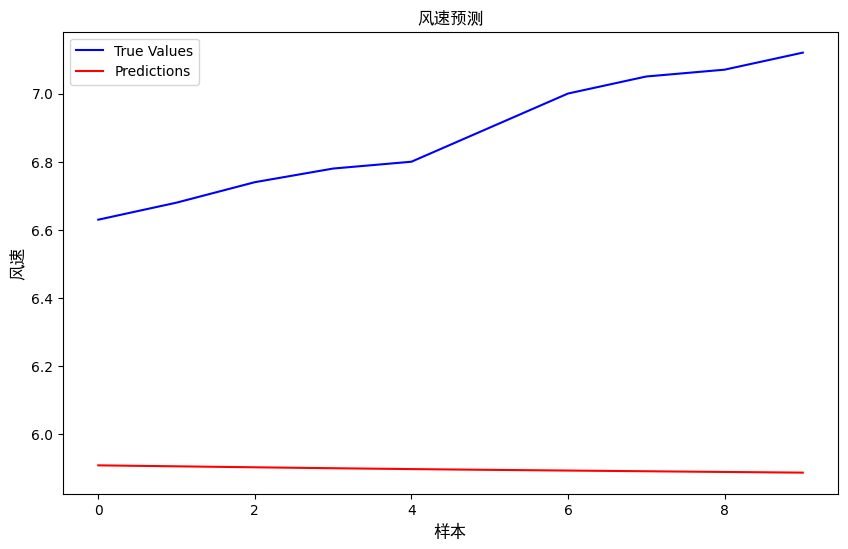

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(truth, label='True Values', color='blue')
plt.plot(preds[100:], label='Predictions', color='red')
plt.title('风速预测',fontproperties=my_font)#
plt.xlabel('样本',fontproperties=my_font)
plt.ylabel('风速',fontproperties=my_font)
plt.legend()
plt.show()